### Stastically motivated model
This is an idea I had for a model which is based purely on two easily observable facts

1. The BPs are clustered around -28 NTs from the acceptor site
2. The BPs are mostly As

By measuring the exact distributions of both of these we can come up with a rough probability that any given NT is a BP. We then just feed these probabilities to SKlearn with some labels to calculate the precision-recall curve and average precision.

Precision-recall curves can be used to find the decision boundary which maximizes F1 and we can calculate both F1 and PER SEQUENCE accuracy.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Load data and split it into train and test (has to be split the same way as for ML tests)

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
%cd "/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2"

/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2


In [59]:
#Assume a folder named dataset exists in the same directory as the code repository
data_path = 'data'

#assume dataset itself is just named dataset.txt
df = pd.read_csv(os.path.join(data_path, "dataset.txt"), delimiter = "\t")

df['BP_POS_WITHIN_STRAND'] = df['IVS_SIZE'] + df['BP_ACC_DIST']

In [60]:
#Import useful functions from repository
from BP_LM.data_preprocessing import split_train_test_on_chr,  extract_intron_seq_and_labels, truncate_strands

In [61]:
df.columns.values

array(['CHR', 'START', 'END', 'STRAND', 'GENE', 'TRANSCRIPT', 'IVS',
       'IVS_SIZE', 'BP_POS', 'BP_ACC_DIST', 'BP_ACC_SEQ', 'IVS_SEQ',
       'BP_POS_WITHIN_STRAND'], dtype=object)

In [62]:
#Create a split based on chromosome types (Alis idea)
#We do this split to keep our tests fair to the machine learning models.
train_chrs = ["chr1", "chr2", "chr3", "chr4",
              "chr5", "chr6", "chr7",
              "chr12", "chr13", "chr14",
              "chr15", "chr16", "chr17", "chr18",
              "chr19", "chr20", "chr21", "chr22",
              "chrX", "chrY"]

test_chrs = ["chr8", "chr11"]
val_chrs = ["chr9", "chr10"]

train_df, test_df, val_df = split_train_test_on_chr(df, train_chrs, val_chrs, test_chrs, shuffle=True)

Chromosomes in train set: {'chr5', 'chr12', 'chr6', 'chr18', 'chr7', 'chr13', 'chr1', 'chr19', 'chr15', 'chrY', 'chr2', 'chr16', 'chr14', 'chr3', 'chr17', 'chr21', 'chr22', 'chrX', 'chr20', 'chr4'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr11', 'chr8'}

Total data points: 177980
Train set contains 147559 data points (82.91%)
Validation set contains 14434 data points (8.11%)
Test set contains 15987 data points (8.98%)


### Compute distributions regarding the BPs

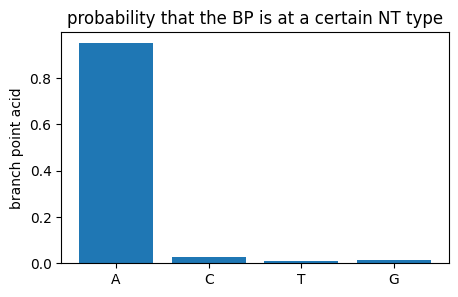

In [63]:
#find probability of a BP being a given nucleotide
base_counts = {"A": 0, "C": 0, "T": 0, "G": 0}

for i, sequence in enumerate(train_df["IVS_SEQ"]):
    base = sequence[train_df["BP_ACC_DIST"][i]]
    if base in base_counts:
        base_counts[base] += 1

As, Cs, Ts, Gs = base_counts["A"], base_counts["C"], base_counts["T"], base_counts["G"]

As /= len(train_df["IVS_SEQ"])
Cs /= len(train_df["IVS_SEQ"])
Ts /= len(train_df["IVS_SEQ"])
Gs /= len(train_df["IVS_SEQ"])

NT_probs = {"A": As, "C" : Cs, "T" : Ts, "G" : Gs}

#Plot probability of NTs
fig, ax = plt.subplots(figsize = (5,3), dpi = 100)
ax.bar(["A", "C", "T", "G"], [As, Cs, Ts, Gs])
ax.set_ylabel('branch point acid')
ax.set_title('probability that the BP is at a certain NT type')
plt.show()

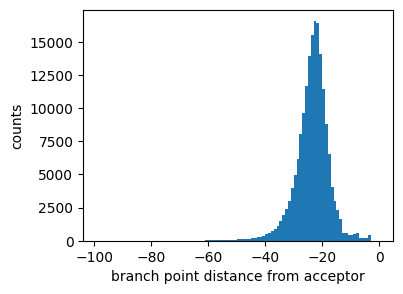

In [64]:
positions = df["BP_ACC_DIST"].to_numpy()

minimum = np.min(positions)
maximum = np.max(positions)
avg = np.mean(positions)

fig, ax = plt.subplots(figsize = (4,3), dpi = 100)
n, bins, patches = ax.hist(positions, 0-minimum, (minimum,0))
ax.set_xlabel("branch point distance from acceptor")
ax.set_ylabel("counts")
fig.show()

In [65]:
location_probabilities = n/len(df["BP_ACC_DIST"]) #normalize the probabilities
positions = bins[:-1] # bins are interval limits so need to crop the end off
truncation_length = np.abs(minimum) #Figure out which interval is important

### Extract sequences and data

In [66]:
#Truncate to the furthest BP seen in the training data, makes things run faster at zero cost to the model performance
test_seqs, test_labels = extract_intron_seq_and_labels(test_df, max_model_input_size=truncation_length, truncate=True)

### Now we define the "model" which will calculate branch point probabilities

In [67]:
#This "model" is quite a lot simpler than the ML approaches
def probability_calculator(seqs, loc_probs, NT_probs):
  """
  input : seqs
    List of DNA strings with the acceptor at the right

  output : probabilities
    List of lists which each have length len(seq) containing probabilities
  """
  probabilities = []
  for seq in seqs:
    loc_probs_copy = loc_probs.copy() # This is necessary to avoid shallow copies overwriting loc_probs globally
    probability = loc_probs_copy[-len(seq):] #Truncate to the right length
    for i, base in enumerate(seq):
      probability[i] *= NT_probs[base] # Account for NT probabilities
    probabilities.append(probability)
  return probabilities

### Apply the model

In [68]:
#Get all the predicted probabilities
probabilities = probability_calculator(test_seqs, location_probabilities, NT_probs)

### Get AP, ideal threshold and F1

In [69]:
#First get AP metrics
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve
def calc_AP(probabilities, labels):

  long_prob = []
  for prob_list in probabilities:
    long_prob += prob_list.tolist()

  long_labels = []
  for label_list in labels:
    long_labels += label_list

  AP = average_precision_score(long_labels, long_prob)
  precision, recall, thresholds = precision_recall_curve(long_labels, long_prob)
  return AP, precision, recall, thresholds

In [70]:
AP, precision, recall, thresholds = calc_AP(probabilities, test_labels)
F1 = np.max(2 * (precision * recall) / (precision + recall))

In [71]:
# Find ideal decision boundary for maximum F1
ideal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
ideal_recall = recall[np.argmax(2 * (precision * recall) / (precision + recall))]

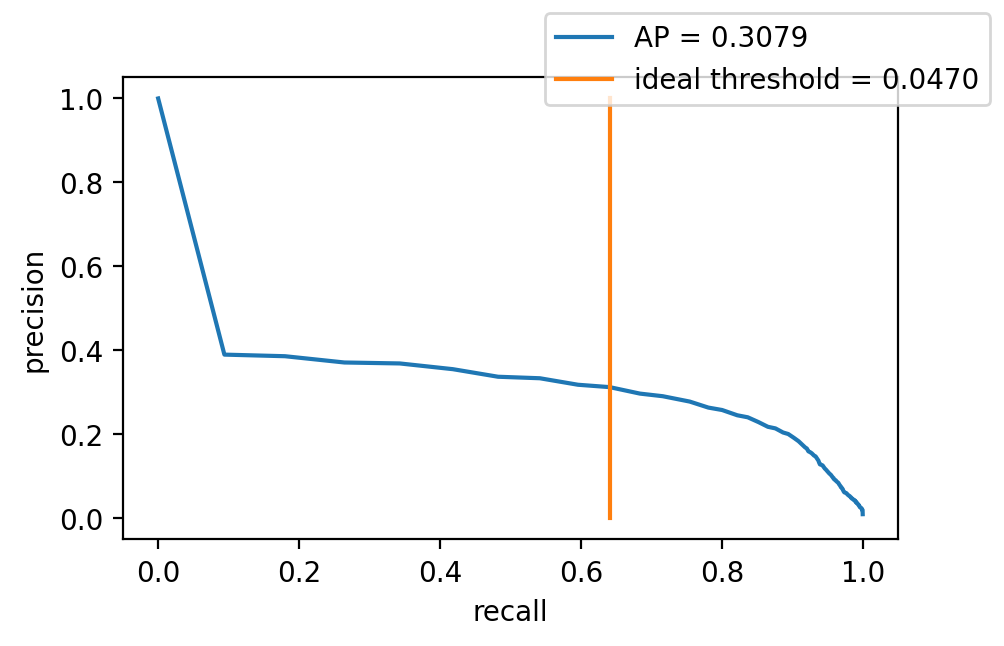

In [72]:
#Plot precision recall curve
fig, ax = plt.subplots(figsize = (5,3), dpi = 200)
ax.plot(recall, precision, label = "AP = {0:.4f}".format(AP))
ax.plot([ideal_recall, ideal_recall], [0,1], label = "ideal threshold = {0:.4f}".format(ideal_threshold))
ax.set_ylabel("precision")
ax.set_xlabel("recall")
fig.legend()

### Calculate accuracy per sequence at ideal decision boundary and check if all predicted BPs are As

In [73]:
def accuracy_calculator(probabilities, labels, threshold, seqs = None):
  N_correct = 0
  all_As = True

  #Find predictions given threshold
  for i, prob_list in enumerate(probabilities):
    prediction = np.where(prob_list > threshold, 1, 0)

    if seqs != None: #If seqs have been passed this checks if all BPs are As
      for index in (np.where(prediction == 1)[0]):
        if seqs[i][index] != "A":
          all_As = False

    #Check if sequence label is entirely correct
    if np.array_equal(prediction, labels[i]):
      N_correct += 1

  if seqs != None:
    print("Are all predicted BPs As? {}".format(all_As))

  return N_correct/len(probabilities)

In [74]:
accuracy = accuracy_calculator(probabilities, test_labels, ideal_threshold, test_seqs)

Are all predicted BPs As? True


### Final Results

In [75]:
final_benchmarks = {"accuracy" : accuracy, "AP" : AP, "F1" : F1}

In [76]:
print(final_benchmarks)

{'accuracy': 0.17652764306498545, 'AP': 0.3079060221645208, 'F1': 0.42026581847097577}
